In [1]:
# --- Import packages ---
import argparse
import h5py
import numpy as np
import os
import pandas as pd
import sys

from pathlib import Path
import matplotlib.pyplot as plt
from pandas.api.types import is_float_dtype 

In [3]:
# --- Functions to read .h5 files ---
# Adapted from ReEDS-2.0/input_processing/ldc_prep.py

def read_h5py_file(filename: Path | str) -> pd.DataFrame:
    """Return dataframe object for a h5py file.

    This function returns a pandas dataframe of a h5py file. If the file has multiple dataset on it
    means it has yearly index.

    Parameters
    ----------
    filename
        File path to read

    Returns
    -------
    pd.DataFrame
        Pandas dataframe of the file
    """
    valid_data_keys = ["data", "cf", "load","evload"]

    with h5py.File(filename, "r") as f:
        keys = list(f.keys())
        datakey = list(set(keys).intersection(valid_data_keys))

        # Adding safety check to validate that it only returns one key
        assert len(datakey) <= 1, f"Multiple keys={datakey} found for {filename}"
        datakey = datakey[0] if datakey else None

        # If none of these keys work, we're dealing with EER-formatted load
        if datakey not in keys:
            years = [column for column in keys if column.isdigit()]

            # Extract all the years and concat them in a single dataframe.
            df = pd.concat({int(y): pd.DataFrame(f[y][...]) for y in years}, axis=0)
            df.index = df.index.rename(["year", "hour"])

        else:
            df = pd.DataFrame(f[datakey][:])
            df.index = pd.Series(f["index"]).values
        df.columns = (
            pd.Series(f["columns"])
            .map(lambda x: x if isinstance(x, str) else x.decode("utf-8"))
            .values
        )
    return df

def read_file(filename: Path | str, **kwargs) -> pd.DataFrame:
    """Return dataframe object of input file for multiple file formats.

    This function read multiple file formats for h5 file sand returns a dataframe from the file. 

    Parameters
    ----------
    filename
        File path to read

    Returns
    -------
    pd.DataFrame
        Pandas dataframe of the file

    Raises
    ------
    FileNotFoundError
        If the file does not exists
    """
    if isinstance(filename, str):
        filename = Path(filename)

    if not filename.exists():
        raise FileNotFoundError(f"Mandatory file {filename} does not exist.")

    # We have two cases, either the data is contained as a single dataframe or we have multiple
    # datasets that composes the h5 file. For a single dataset we use pandas (since it is the most
    # convenient) and h5py for the custom h5 file.
    try:
        df = pd.read_hdf(filename)

    except ValueError:
        df = read_h5py_file(filename)
    
    # All values being NaN indicates that the region filtering in copy_files.py removed all
    # data, leaving an empty dataframe.
    # Return an empty dataframe with the original file's index if all values are NaN
    if all(df.isnull().all()):
        df = df.drop(columns=0)
        return df

    # NOTE: Some files are saved as float16, so we cast to float32 to prevent issues with
    # large/small numbers
    numeric_cols = [c for c in df if is_float_dtype(df[c].dtype)]
    df = df.astype({column:np.float32 for column in numeric_cols})
    
    return df

C:\Users\sshi\AppData\Local\Temp\1\ipykernel_27808\3139545898.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['National Load'] = df.sum(axis=1)                  # sum over all BAs
C:\Users\sshi\AppData\Local\Temp\1\ipykernel_27808\3139545898.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['National Load'] = df.sum(axis=1)                  # sum over all BAs


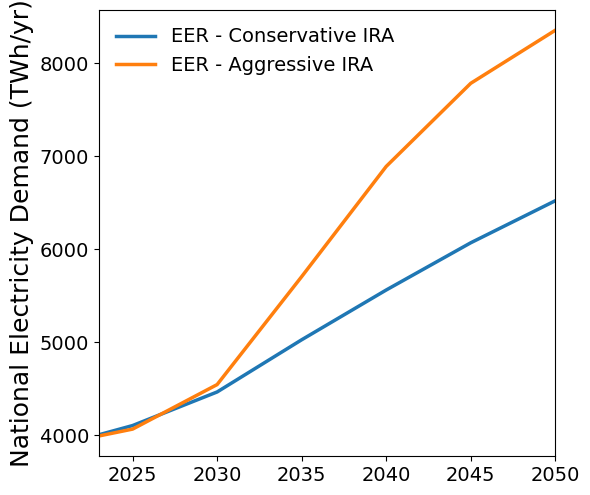

In [14]:
# --- Read Data files ---
folder = 'C:\\Users\\sshi\\Documents\\GitHub\\ReEDS-2.0\\inputs\\load'

files = [os.path.join(folder, 'EER_IRAlow_load_hourly.h5'),
         os.path.join(folder, 'EER_100by2050_load_hourly.h5')]


data_frames = []
for file in files:
    df = read_file(file)
    df = df[df.index.get_level_values('year') >= 2023]    # filter year
    df = df[df.index.get_level_values('hour') < 8760]     # for each year the load data is repeated 7 times, only need 8760 hours (1 year)      
    df['National Load'] = df.sum(axis=1)                  # sum over all BAs
    graph_data = df['National Load'] / 1e6                # convert MWh to TWh
    year_data = graph_data.groupby(level='year').sum()    # sum over years
    data_frames.append(year_data)

# Initialize plot
fig, axs = plt.subplots(figsize = (6,5.05))

# Customize labels and colors
labels = ['EER - Conservative IRA','EER - Aggressive IRA']
#colors = ['blue','orange']

# Loop through each load profile and plot in teh same figure
for data, label in zip(data_frames,labels):
    axs.plot(data.index,data.values, label=label, lw=2.5)

# Customize the plot
axs.set_xlim(2023,2050)
#axs.set_xlabel('Year', fontsize=12)
axs.set_ylabel('National Electricity Demand (TWh/yr)', fontsize=18)
axs.legend(fontsize=14, loc='upper left',frameon=False) 
axs.tick_params(axis='both', labelsize=14) 

# Adjust layout
plt.tight_layout()


In [9]:
# Customize the plot
axs.set_xlim(2023,2050)
#axs.set_xlabel('Year', fontsize=12)
axs.set_ylabel('National Electricity Demand (TWh/year)', fontsize=18)
axs.legend(fontsize=14, loc='upper left',frameon=False) 
axs.tick_params(axis='both', labelsize=14) 
plt.show()

Carbon Constraint Profiles

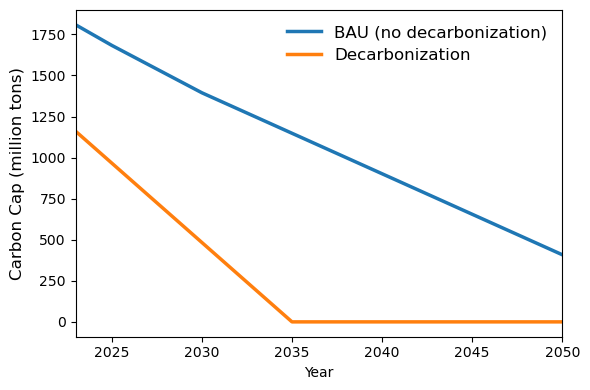

In [11]:
# Load carbon constraint data

folder = "C:\\Users\\sshi\\Documents\\GitHub\\ReEDS-2.0\\inputs\\emission_constraints"
file = os.path.join(folder, 'co2_cap.csv')

data = pd.read_csv(file, index_col='t')
data.columns = data.columns.astype(int)
ccap_df = data.loc[(data.index.isin(['default', 'start2023_80pct2030_100pct2035'])),         # filter scenarios
                   (data.columns >= 2023) ]             # filter years

# Give profiles new names
ccap_df.index = ['BAU (no decarbonization)', 'Decarbonization'] 

# Initialize plotting
plt.figure(figsize=(6,4))

# Plot each row
for index, row in ccap_df.iterrows():
    plt.plot(ccap_df.columns, row/1e6, linestyle='-', label=index, lw=2.5)

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Carbon Cap (million tons)', fontsize=12)
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)
plt.xlim(2023, 2050)
#plt.ylim(0,)
plt.legend(frameon=False, fontsize=12)
#plt.grid(True)
plt.tight_layout()

In [27]:
data.columns

Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045,
       2046, 2047, 2048, 2049, 2050],
      dtype='int32')